In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import itertools
from itertools import cycle

from glob import glob # allows us to list all files to a directory


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
Ravdess = "D:/PYTHON/Speech_Emotion_recognition/audio_speech_actors_01-24/"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))

In [ ]:
Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

In [ ]:
Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotion                                               Path
0  neutral  D:/PYTHON/Speech_Emotion_recognition/audio_spe...
1  neutral  D:/PYTHON/Speech_Emotion_recognition/audio_spe...
2  neutral  D:/PYTHON/Speech_Emotion_recognition/audio_spe...
3  neutral  D:/PYTHON/Speech_Emotion_recognition/audio_spe...
4  neutral  D:/PYTHON/Speech_Emotion_recognition/audio_spe...

In [ ]:
df = pd.concat([Ravdess_df], axis=0)
df.shape

(1440, 2)

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    fig, ax = plt.subplots(figsize=(10,5))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    img = librosa.display.specshow(Xdb, x_axis='time', y_axis='hz', ax=ax)
    fig.colorbar(img, ax=ax, format=f'%0.2f');

### Waveplots for different audio files

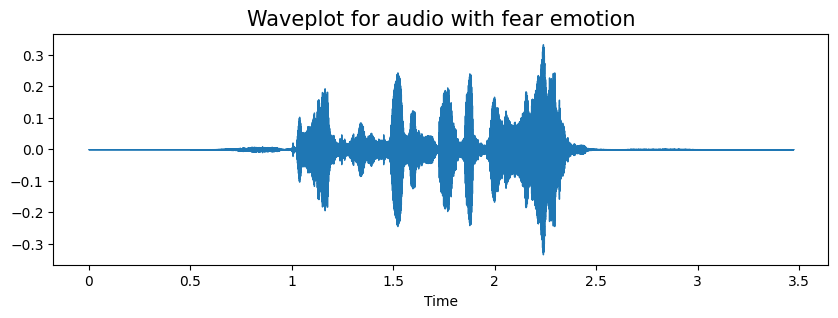

In [ ]:
# Picking a fearful track
fname = Ravdess + '/Actor_14/03-01-06-02-02-02-14.wav'
data, sampling_rate = librosa.load(fname)
emotion = 'fear'
create_waveplot(data,sampling_rate,emotion)

# Lets play the audio
ipd.Audio(fname)

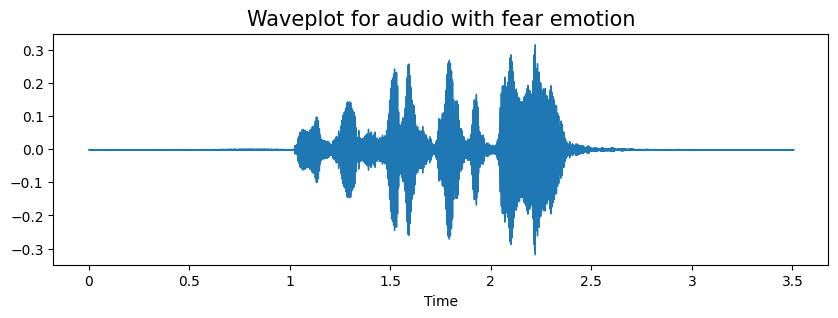

In [ ]:
# Picking another fearful track
fname = Ravdess + '/Actor_15/03-01-06-02-02-02-15.wav'
data, sampling_rate = librosa.load(fname)
emotion = 'fear'
create_waveplot(data,sampling_rate,emotion)

# Lets play the audio
ipd.Audio(fname)

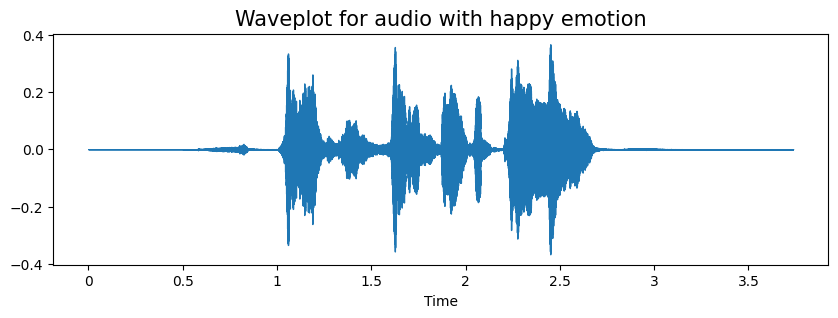

In [ ]:
# Picking a happy track
fname = Ravdess + '/Actor_14/03-01-03-02-02-02-14.wav'
data, sampling_rate = librosa.load(fname)
emotion = 'happy'
create_waveplot(data,sampling_rate,emotion)

# Lets play the audio
ipd.Audio(fname)

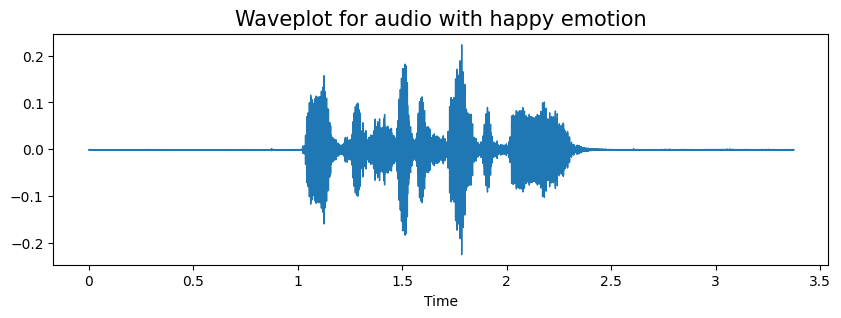

In [ ]:
# Picking another happy track
fname = Ravdess + '/Actor_15/03-01-03-02-02-02-15.wav'
data, sampling_rate = librosa.load(fname)
emotion = 'happy'
create_waveplot(data,sampling_rate,emotion)

# Lets play the audio
ipd.Audio(fname)

### Trimmed Audio Files

In [ ]:
def Trim_waveplot(data, sr, e):
  plt.figure(figsize=(10, 5))
  plt.title('Trimmed Waveplot for audio with {} emotion'.format(e), size=15)
  data_trimmed, _ = librosa.effects.trim(data, top_db=20)
  librosa.display.waveshow(data_trimmed, sr=sampling_rate)
  return data_trimmed , sampling_rate
  plt.show()

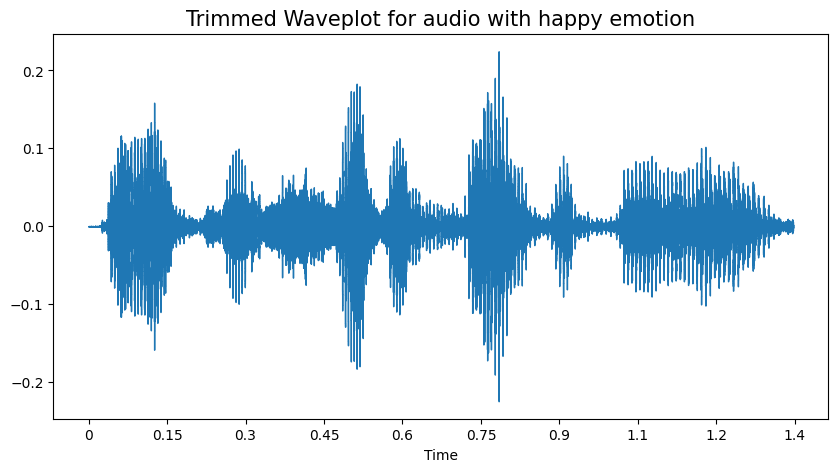

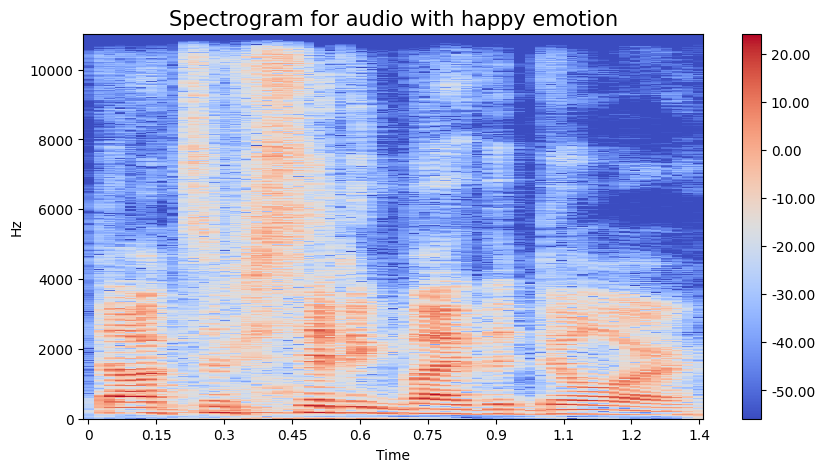

In [ ]:
#Happy track example
fname = Ravdess + '/Actor_15/03-01-03-02-02-02-15.wav'
data, sampling_rate = librosa.load(fname)
emotion = 'happy'
ad_trimmed , samp_rate = Trim_waveplot(data,sampling_rate,emotion)
create_spectrogram(ad_trimmed,samp_rate,emotion)

# Lets play the audio
ipd.Audio(fname)

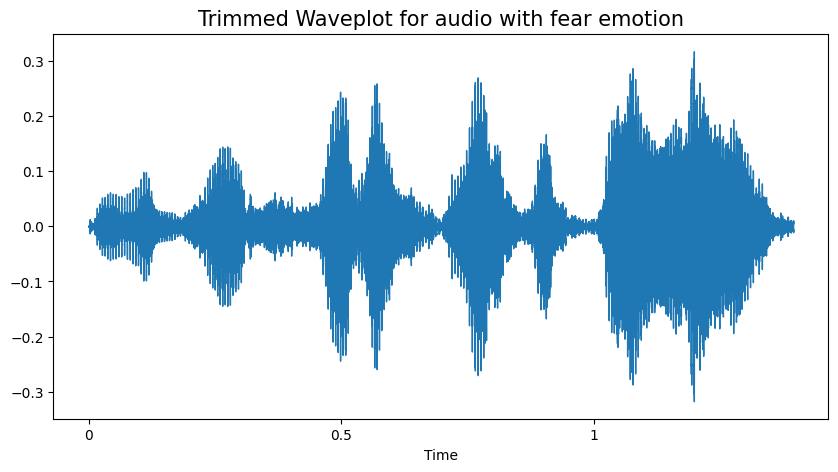

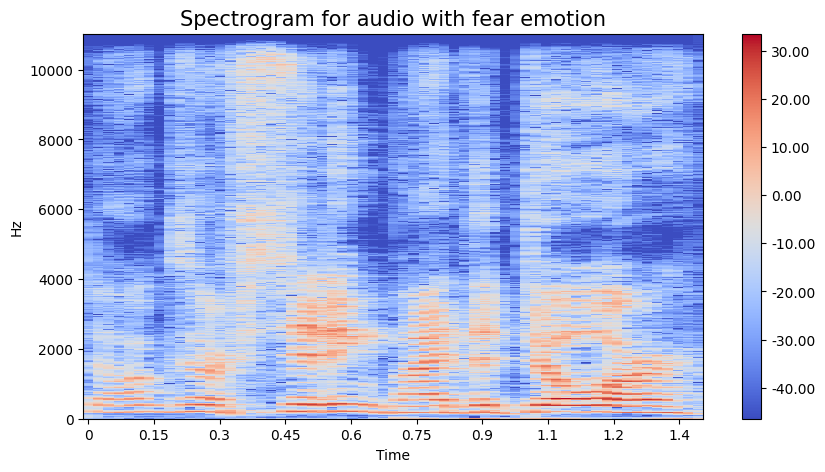

In [ ]:
#fear track example
fname = Ravdess + '/Actor_15/03-01-06-02-02-02-15.wav'
data, sampling_rate = librosa.load(fname)
emotion = 'fear'
ad_trimmed , samp_rate = Trim_waveplot(data,sampling_rate,emotion)
create_spectrogram(ad_trimmed,samp_rate,emotion)

# Lets play the audio
ipd.Audio(fname)

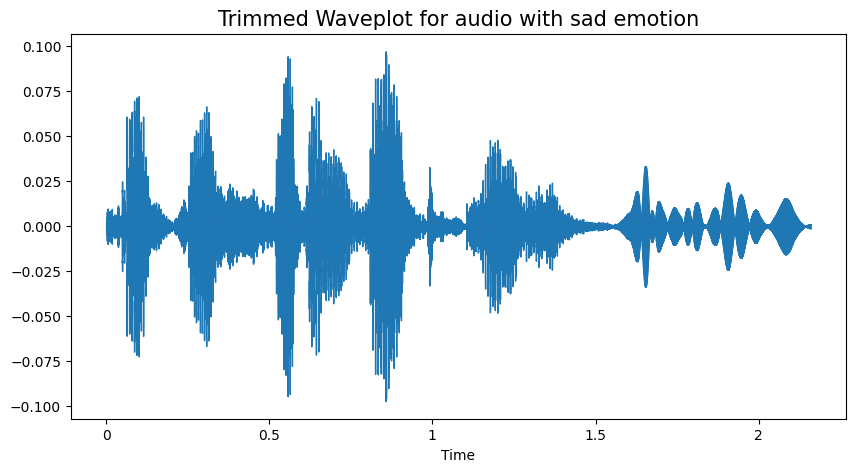

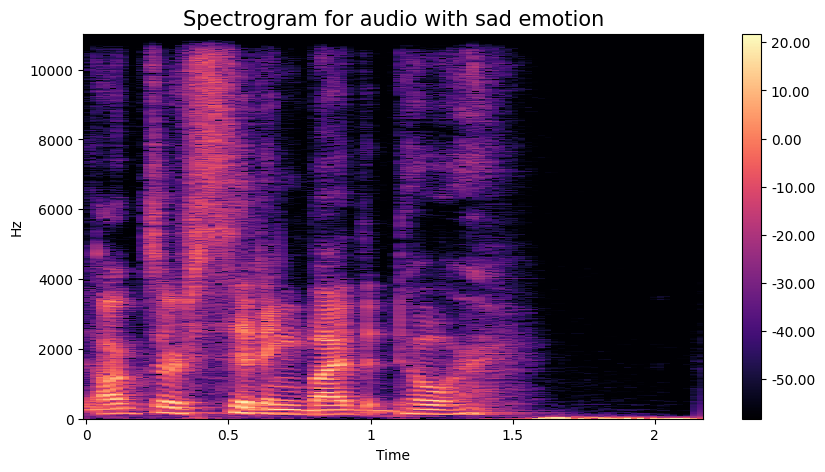

In [ ]:
#sad track example
fname = Ravdess + '/Actor_15/03-01-04-02-02-02-15.wav'
data, sampling_rate = librosa.load(fname)
emotion = 'sad'
ad_trimmed , samp_rate = Trim_waveplot(data,sampling_rate,emotion)
create_spectrogram(ad_trimmed,samp_rate,emotion)

# Lets play the audio
ipd.Audio(fname)

## Data augmentation

We have some ways for data augmentation in sound data:

1. Noise injection
2. Stretching
3. Shifting
4. Pitching

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data,rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

### Example of a audio file with data augmentation

1. Noised audio

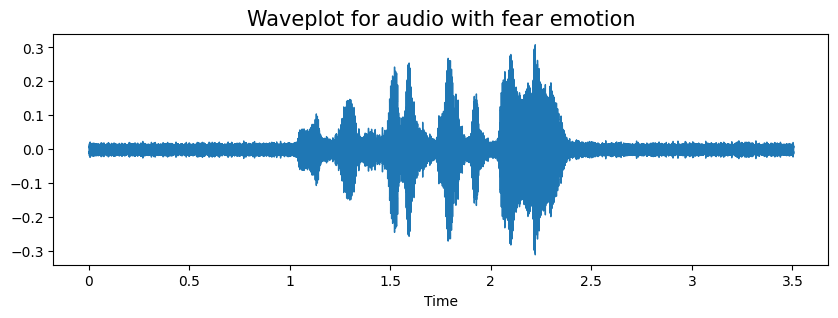

In [ ]:
#Fear track example
fname = Ravdess + '/Actor_15/03-01-06-02-02-02-15.wav'
data, sampling_rate = librosa.load(fname)
emotion = 'fear'
x = noise(data)
create_waveplot(x,sampling_rate,emotion)
Audio(x,rate = sampling_rate)

2. Stretched Audio

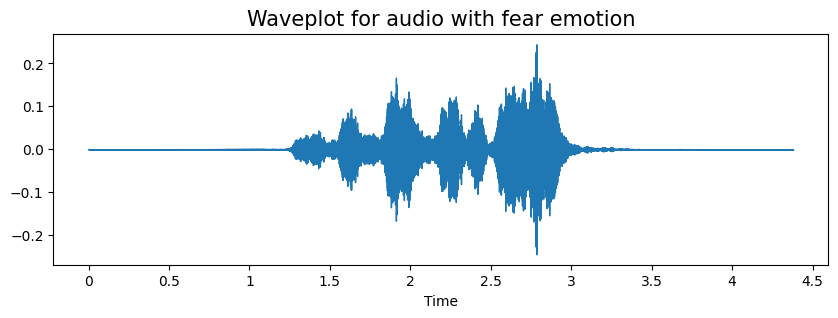

In [ ]:
x = stretch(data)
create_waveplot(x,sampling_rate,emotion)
Audio(x,rate = sampling_rate)

3. Pitched Audio

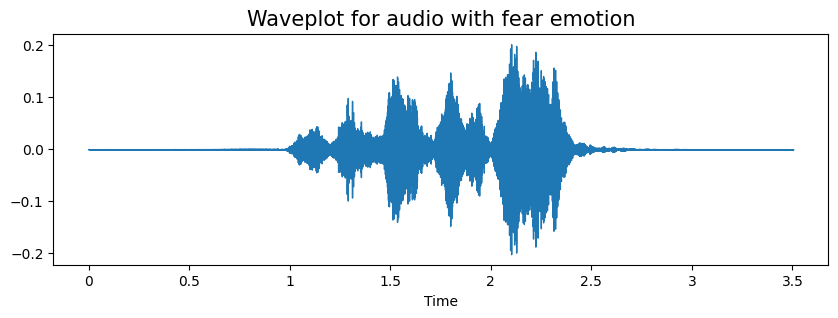

In [ ]:
x = pitch(data,sampling_rate)
create_waveplot(x,sampling_rate,emotion)
Audio(x,rate = sampling_rate)

For our data augmentation we will use noise and pitch and combination with both of it.

In [ ]:
n_fft = 2048
hop_length = 512

## Feature extraction

#### There are some features may be useful:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
3. Spectral Centroid : The center of gravity of the spectrum.
4. Spectral Spread : The second central moment of the spectrum.
5. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
6. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
7. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
8. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [ ]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


# def spc_entropy(data, sr):
#     spc_en = spectral_entropy(data, sf=sr, method="fft")
#     return spc_en

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [ ]:
path = np.array(df["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

54458

In [ ]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):

    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

### Function for extracting features

In [ ]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        #zcr(data, frame_length, hop_length),
                        # np.mean(energy(data, frame_length, hop_length),axis=0),
                        # np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        #rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
                        # mel_spc(data, sr, frame_length, hop_length, flatten=True)
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

### Function for getting features

In [ ]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result


### Extraction

In [ ]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(df.Path, df.Emotion, range(df.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
Done.


In [ ]:
features_path = "./features_sml.csv"

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['labels'] = Y
Emotions.to_csv(features_path, index=False)
Emotions.head()

0         1         2         3         4         5         6  \
0 -856.323669  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1 -636.230152 -9.734604  1.436753  3.068282  0.962892 -1.120698 -6.172407   
2 -904.339050  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3 -663.319764 -5.111032 -5.237911 -9.031102 -6.129775  6.047112  4.955899   
4 -859.724792  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7         8         9  ...      2151      2152      2153      2154  \
0  0.000000  0.000000  0.000000  ...  0.766315  0.755441  0.743671  0.731043   
1 -7.406898 -6.436699 -7.504871  ... -3.173387 -0.783695  1.760563  1.080807   
2  0.000000  0.000000  0.000000  ...  0.006713  0.006601  0.006483  0.006356   
3  4.997620 -2.383651  3.892464  ...  2.214695  3.295153  1.521879  2.456574   
4  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

       2155      2156      2157      2158      2159   labels  
0  0.717561  0.703260  0.688124  0.672208  0.655518  neutral  
1  0.865485 -3.716637 -4.104830 -0.436558  2.909805  neutral  
2  0.006218  0.006066  0.005919  0.005759  0.005588  neutral  
3  5.504350 -0.475200  1.965421  0.713527  4.002167  neutral  
4  0.000000  0.000000  0.000000  0.000000  0.000000  neutral  

[5 rows x 2161 columns]

In [ ]:
Emotions = pd.read_csv(features_path)
print(Emotions.shape)

(5760, 2161)


In [ ]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(5760, 2161)


In [ ]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2156      False
2157      False
2158      False
2159      False
labels    False
Length: 2161, dtype: bool


(5760, 2161)

In [ ]:
# Fill NaN with 0
Emotions = Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2156      False
2157      False
2158      False
2159      False
labels    False
Length: 2161, dtype: bool


(5760, 2161)

In [ ]:
X_new = Emotions.iloc[: ,:-1].values
Y_new = Emotions['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y_new
encoder = OneHotEncoder()
Y_new = encoder.fit_transform(np.array(Y_new).reshape(-1,1)).toarray()

In [ ]:
# Train and Test Split
x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 2160), (4320, 7), (1440, 2160), (1440, 7))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, test_size=0.1, shuffle=True)
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((3888, 2160), (1440, 2160), (432, 2160), (3888, 7), (1440, 7), (432, 7))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3888, 2160), (3888, 7), (1440, 2160), (1440, 7))

# DECISION TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier
#clf3 = DecisionTreeClassifier()

#clf3 = clf3.fit(x_train,y_train)

#y_pred = clf3.predict(x_test)

In [ ]:
for max_d in range(1,30):
  model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
  model.fit(x_train, y_train)
  print('The Training Accuracy for max_depth {} is:'.format(max_d), model.score(x_train, y_train))
  print('The Validation Accuracy for max_depth {} is:'.format(max_d), model.score(x_val,y_val))
  print('')

The Training Accuracy for max_depth 1 is: 0.0
The Validation Accuracy for max_depth 1 is: 0.0

The Training Accuracy for max_depth 2 is: 0.14531893004115226
The Validation Accuracy for max_depth 2 is: 0.12268518518518519

The Training Accuracy for max_depth 3 is: 0.14068930041152264
The Validation Accuracy for max_depth 3 is: 0.1111111111111111

The Training Accuracy for max_depth 4 is: 0.22633744855967078
The Validation Accuracy for max_depth 4 is: 0.18518518518518517

The Training Accuracy for max_depth 5 is: 0.2767489711934156
The Validation Accuracy for max_depth 5 is: 0.2013888888888889

The Training Accuracy for max_depth 6 is: 0.3204732510288066
The Validation Accuracy for max_depth 6 is: 0.22453703703703703

The Training Accuracy for max_depth 7 is: 0.39814814814814814
The Validation Accuracy for max_depth 7 is: 0.25462962962962965

The Training Accuracy for max_depth 8 is: 0.4781378600823045
The Validation Accuracy for max_depth 8 is: 0.29398148148148145

The Training Accuracy

In [ ]:
train_inputs = pd.DataFrame(x_train)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf3 = DecisionTreeClassifier(max_depth=21, random_state=42)

clf3 = clf3.fit(x_train,y_train)

y_pred = clf3.predict(x_test)

[Text(0.4838899748151926, 0.9772727272727273, '580 <= -0.556\ngini = 0.244\nsamples = 3888\nvalue = [[3378, 510]\n[3352, 536]\n[3347, 541]\n[3382, 506]\n[3113, 775]\n[3383, 505]\n[3373, 515]]'),
 Text(0.14900576906203386, 0.9318181818181818, '1102 <= 0.434\ngini = 0.2\nsamples = 1172\nvalue = [[1148, 24]\n[1053, 119]\n[1099, 73]\n[1110, 62]\n[612, 560]\n[910, 262]\n[1100, 72]]'),
 Text(0.06566969377906466, 0.8863636363636364, '1280 <= -1.008\ngini = 0.221\nsamples = 625\nvalue = [[608, 17]\n[548, 77]\n[584, 41]\n[570, 55]\n[409, 216]\n[457, 168]\n[574, 51]]'),
 Text(0.039045362814775816, 0.8409090909090909, '1443 <= 0.309\ngini = 0.183\nsamples = 251\nvalue = [[247, 4]\n[227, 24]\n[245, 6]\n[243, 8]\n[119, 132]\n[184, 67]\n[241, 10]]'),
 Text(0.02123365798017022, 0.7954545454545454, '581 <= -0.645\ngini = 0.15\nsamples = 162\nvalue = [[158, 4]\n[158, 4]\n[157, 5]\n[157, 5]\n[55, 107]\n[132, 30]\n[155, 7]]'),
 Text(0.010529086601737299, 0.75, '545 <= 0.146\ngini = 0.212\nsamples = 55\nv

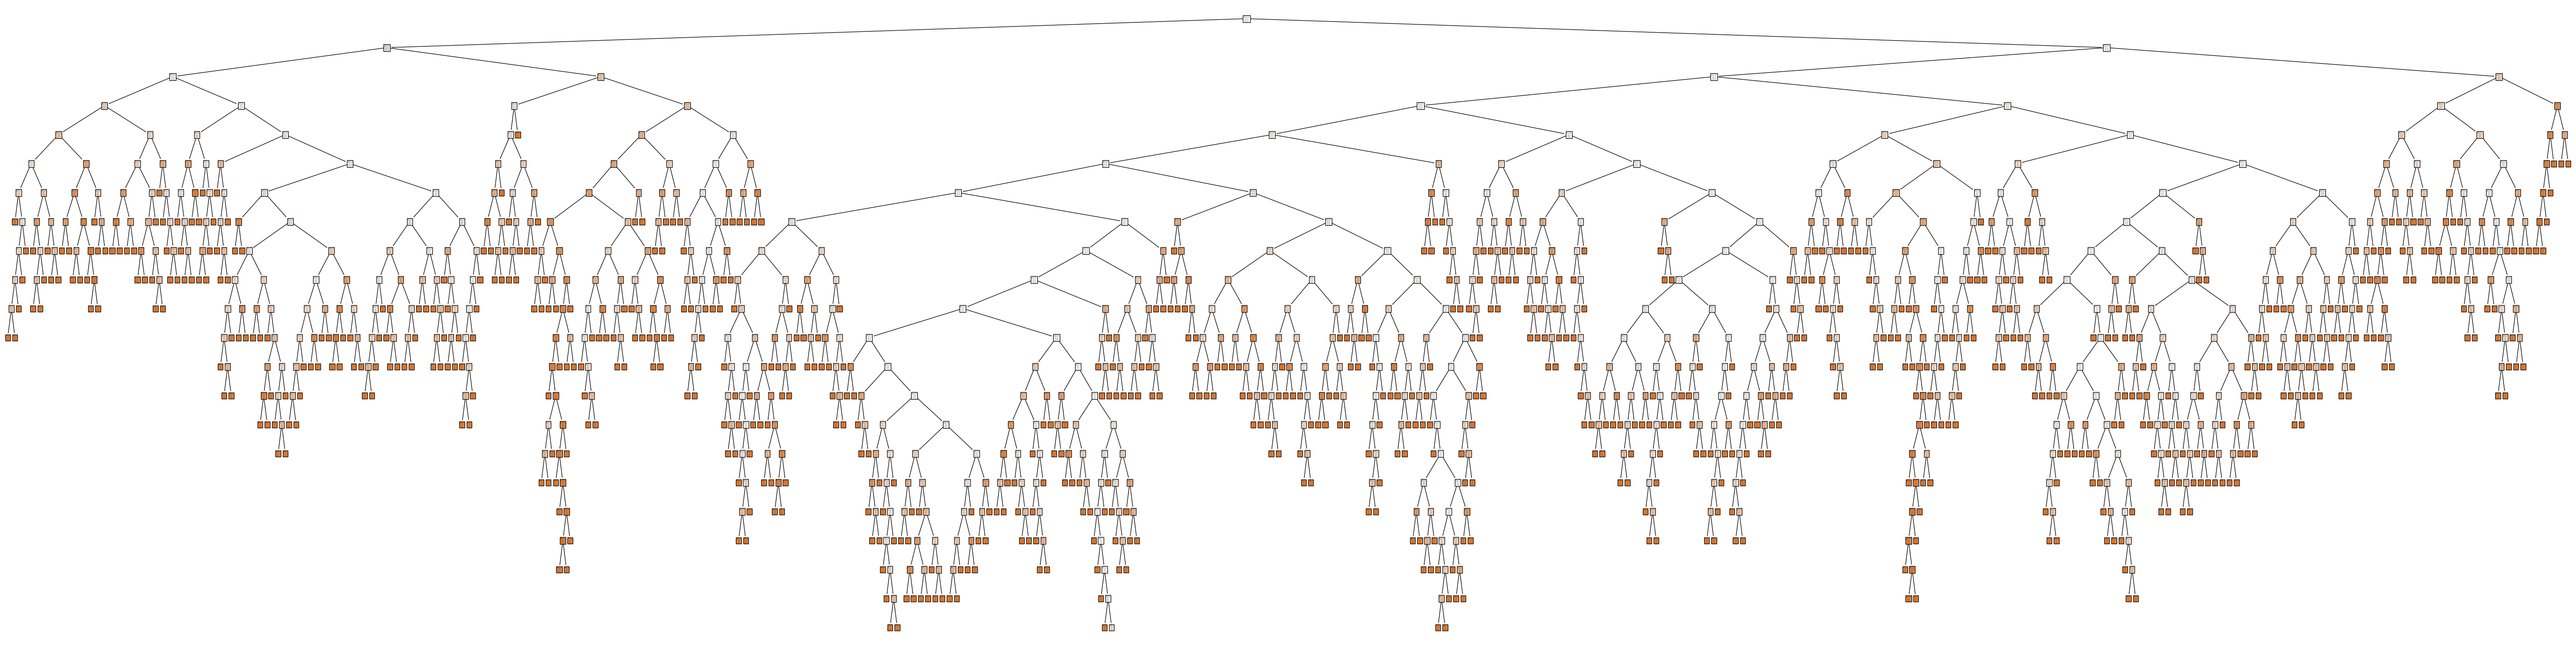

In [ ]:
from sklearn.tree import plot_tree, export_text
plt.figure(figsize =(80,20))

plot_tree(clf3, feature_names=train_inputs.columns, max_depth=21, filled=True)

In [ ]:
print("Training set score: {:.3f}".format(clf3.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf3.score(x_test, y_test)))

Training set score: 0.999
Test set score: 0.489


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.60      0.62       196
           1       0.45      0.45      0.45       175
           2       0.45      0.47      0.46       191
           3       0.48      0.45      0.46       206
           4       0.59      0.55      0.57       293
           5       0.37      0.40      0.38       192
           6       0.44      0.47      0.45       187

   micro avg       0.49      0.49      0.49      1440
   macro avg       0.49      0.48      0.48      1440
weighted avg       0.49      0.49      0.49      1440
 samples avg       0.49      0.49      0.49      1440



# XGBOOST

In [ ]:
!pip install xgboost

                                              0.0/70.9 MB ? eta -:--:--
                                              0.2/70.9 MB 6.1 MB/s eta 0:00:12
                                              0.6/70.9 MB 7.0 MB/s eta 0:00:11
                                              0.9/70.9 MB 8.0 MB/s eta 0:00:09
                                              1.1/70.9 MB 7.1 MB/s eta 0:00:10
                                              1.5/70.9 MB 7.3 MB/s eta 0:00:10
                                              1.8/70.9 MB 7.4 MB/s eta 0:00:10
     -                                        1.9/70.9 MB 6.9 MB/s eta 0:00:11
     -                                        2.3/70.9 MB 6.9 MB/s eta 0:00:10
     -                                        2.6/70.9 MB 6.9 MB/s eta 0:00:10
     -                                        2.9/70.9 MB 7.2 MB/s eta 0:00:10
     -                                        3.2/70.9 MB 7.1 MB/s eta 0:00:10
     -                                        3.3/70.9 MB 6

In [ ]:
from xgboost import XGBClassifier

In [ ]:
clf04 = XGBClassifier()
clf04.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
y_pred = clf04.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.81%


# KNN

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#clf1=KNeighborsClassifier(n_neighbors=4)
#clf1.fit(x_train,y_train)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4,metric='minkowski')
knn.fit(x_train,y_train)
y_preds = knn.predict(x_test)
print(f"The accuracy of the model is {accuracy_score(y_test,y_preds)}")

# Classification Report
print(classification_report(y_test,y_preds))

The accuracy of the model is 0.625
              precision    recall  f1-score   support

           0       0.97      0.60      0.74       196
           1       0.97      0.62      0.76       175
           2       0.95      0.63      0.76       191
           3       0.96      0.48      0.64       206
           4       0.87      0.81      0.84       293
           5       0.94      0.54      0.68       192
           6       0.98      0.62      0.76       187

   micro avg       0.94      0.62      0.75      1440
   macro avg       0.95      0.61      0.74      1440
weighted avg       0.95      0.62      0.75      1440
 samples avg       0.62      0.62      0.62      1440



In [ ]:
knn = KNeighborsClassifier(n_neighbors=5,metric='minkowski')
knn.fit(x_train,y_train)
y_preds = knn.predict(x_test)
print(f"The accuracy of the model is {accuracy_score(y_test,y_preds)}")

# Classification Report
print(classification_report(y_test,y_preds))

The accuracy of the model is 0.6798611111111111
              precision    recall  f1-score   support

           0       0.92      0.67      0.78       196
           1       0.95      0.66      0.78       175
           2       0.88      0.67      0.76       191
           3       0.93      0.54      0.68       206
           4       0.76      0.87      0.81       293
           5       0.84      0.58      0.69       192
           6       0.94      0.67      0.79       187

   micro avg       0.87      0.68      0.76      1440
   macro avg       0.89      0.67      0.76      1440
weighted avg       0.88      0.68      0.76      1440
 samples avg       0.68      0.68      0.68      1440



In [ ]:
knn = KNeighborsClassifier(n_neighbors=7,metric='minkowski')
knn.fit(x_train,y_train)
y_preds = knn.predict(x_test)
print(f"The accuracy of the model is {accuracy_score(y_test,y_preds)}")

# Classification Report
print(classification_report(y_test,y_preds))

The accuracy of the model is 0.5784722222222223
              precision    recall  f1-score   support

           0       0.92      0.56      0.70       196
           1       0.94      0.51      0.66       175
           2       0.89      0.59      0.71       191
           3       0.94      0.39      0.55       206
           4       0.73      0.84      0.78       293
           5       0.84      0.49      0.62       192
           6       0.94      0.54      0.69       187

   micro avg       0.85      0.58      0.69      1440
   macro avg       0.89      0.56      0.67      1440
weighted avg       0.88      0.58      0.68      1440
 samples avg       0.58      0.58      0.58      1440



In [ ]:
knn = KNeighborsClassifier(n_neighbors=4,metric='cosine')
knn.fit(x_train,y_train)
y_preds = knn.predict(x_test)
print(f"The accuracy of the model is {accuracy_score(y_test,y_preds)}")

# Classification Report
print(classification_report(y_test,y_preds))

The accuracy of the model is 0.7229166666666667
              precision    recall  f1-score   support

           0       0.96      0.77      0.85       196
           1       0.97      0.72      0.83       175
           2       0.96      0.70      0.81       191
           3       0.98      0.58      0.73       206
           4       0.93      0.86      0.89       293
           5       0.96      0.64      0.77       192
           6       0.98      0.72      0.83       187

   micro avg       0.96      0.72      0.82      1440
   macro avg       0.96      0.71      0.82      1440
weighted avg       0.96      0.72      0.82      1440
 samples avg       0.72      0.72      0.72      1440



In [ ]:
clf1 = KNeighborsClassifier(n_neighbors=5,metric='cosine')
clf1.fit(x_train,y_train)
y_preds = clf1.predict(x_test)
print(f"The accuracy of the model is {accuracy_score(y_test,y_preds)}")

# Classification Report
print(classification_report(y_test,y_preds))

The accuracy of the model is 0.7770833333333333
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       196
           1       0.96      0.75      0.84       175
           2       0.91      0.77      0.84       191
           3       0.95      0.65      0.77       206
           4       0.84      0.90      0.87       293
           5       0.86      0.71      0.77       192
           6       0.93      0.78      0.85       187

   micro avg       0.90      0.78      0.83      1440
   macro avg       0.91      0.77      0.83      1440
weighted avg       0.90      0.78      0.83      1440
 samples avg       0.78      0.78      0.78      1440



In [ ]:
knn = KNeighborsClassifier(n_neighbors=7,metric='cosine')
knn.fit(x_train,y_train)
y_preds = knn.predict(x_test)
print(f"The accuracy of the model is {accuracy_score(y_test,y_preds)}")

# Classification Report
print(classification_report(y_test,y_preds))

The accuracy of the model is 0.68125
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       196
           1       0.94      0.65      0.77       175
           2       0.89      0.65      0.75       191
           3       0.97      0.49      0.65       206
           4       0.83      0.87      0.85       293
           5       0.87      0.55      0.67       192
           6       0.95      0.71      0.81       187

   micro avg       0.89      0.68      0.77      1440
   macro avg       0.90      0.67      0.76      1440
weighted avg       0.90      0.68      0.76      1440
 samples avg       0.68      0.68      0.68      1440



In [ ]:
y_pred=clf1.predict(x_test)

In [ ]:
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

Training set score: 0.898
Test set score: 0.777


# SVM

In [ ]:
X_new_svm = Emotions.iloc[: ,:-1].values
Y_new_svm = Emotions['labels'].values

In [ ]:
# Train and Test Split
x_train, x_test, y_train, y_test = train_test_split(X_new_svm, Y_new_svm, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 2160), (4320,), (1440, 2160), (1440,))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 2160), (4320,), (1440, 2160), (1440,))

In [ ]:
#Fit SVM to the Training set
from sklearn.svm import SVC
classifier_svm = SVC(kernel = 'rbf', random_state = 0)
classifier_svm.fit(x_train, y_train)

SVC(random_state=0)

In [ ]:
y_pred=classifier_svm.predict(x_test)

In [ ]:
print("Training set score: {:.3f}".format(classifier_svm.score(x_train, y_train)))
print("Test set score: {:.3f}".format(classifier_svm.score(x_test, y_test)))

Training set score: 0.973
Test set score: 0.891


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.94      0.88      0.91       196
     disgust       0.85      0.96      0.90       175
        fear       0.89      0.85      0.87       191
       happy       0.91      0.87      0.89       206
     neutral       0.86      0.95      0.90       293
         sad       0.91      0.80      0.85       192
    surprise       0.91      0.90      0.90       187

    accuracy                           0.89      1440
   macro avg       0.90      0.89      0.89      1440
weighted avg       0.89      0.89      0.89      1440



# NAVIE BAYES

In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier_nb = GaussianNB()
classifier_nb.fit(x_train, y_train)

GaussianNB()

In [ ]:
y_pred=classifier_nb.predict(x_test)

In [ ]:
print("Training set score: {:.3f}".format(classifier_svm.score(x_train, y_train)))
print("Test set score: {:.3f}".format(classifier_svm.score(x_test, y_test)))

Training set score: 0.973
Test set score: 0.891


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.63      0.56      0.59       196
     disgust       0.45      0.52      0.48       175
        fear       0.57      0.34      0.42       191
       happy       0.50      0.14      0.21       206
     neutral       0.52      0.73      0.61       293
         sad       0.35      0.17      0.23       192
    surprise       0.33      0.69      0.44       187

    accuracy                           0.46      1440
   macro avg       0.48      0.45      0.43      1440
weighted avg       0.48      0.46      0.44      1440



# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

In [ ]:
def model_fitting(x_train,y_train):
  model1 = RandomForestClassifier(n_estimators=10,n_jobs = -1)
  model2 = RandomForestClassifier(n_estimators=20,n_jobs =1)
  model3 = RandomForestClassifier(n_estimators=30,n_jobs = 2)
  model1.fit(x_train,y_train)
  model2.fit(x_train,y_train)
  model3.fit(x_train,y_train)
  return model1,model2,model3

In [ ]:
model1,model2,model3 = model_fitting(x_train,y_train)

In [ ]:
accuracy = [accuracy_score(y_test,model1.predict(x_test)),
            accuracy_score(y_test,model2.predict(x_test)),
            accuracy_score(y_test,model3.predict(x_test))]

In [ ]:
# Evaluating the models
print(f"Accuracy for model1 with n_estimators = 10 and n_jobs = -1: {accuracy[0]}")
print(f"Accuracy for model1 with n_estimators = 20 and n_jobs = 1: {accuracy[1]}")
print(f"Accuracy for model1 with n_estimators = 30 and n_jobs = 2: {accuracy[2]}")

Accuracy for model1 with n_estimators = 10 and n_jobs = -1: 0.27152777777777776
Accuracy for model1 with n_estimators = 20 and n_jobs = 1: 0.27569444444444446
Accuracy for model1 with n_estimators = 30 and n_jobs = 2: 0.2701388888888889


# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
clf2=MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=500)
clf2.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=270, hidden_layer_sizes=(400,),
              learning_rate='adaptive', max_iter=500)

In [ ]:
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))

Training set score: 1.000
Test set score: 0.846


In [ ]:
# Predict for the test set
y_pred=clf2.predict(x_test)

In [ ]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 84.58%


In [ ]:

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test,y_pred)
print (matrix)

In [ ]:

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))


# CNN

In [ ]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [ ]:
lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4608, 2160), (1152, 2160), (4608, 7), (1152, 7))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((4147, 2160), (1152, 2160), (461, 2160), (4147, 7), (1152, 7), (461, 7))

In [ ]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((4147, 2160), (1152, 2160), (461, 2160), (4147, 7), (1152, 7), (461, 7))

In [ ]:
# We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(4147, 2160, 1)

### Let's define our model:

In [ ]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

#model.add(layers.Conv1D(512, kernel_size=5, strides=1,
#                        padding="same", activation="relu"))
#model.add(layers.BatchNormalization())
#model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

#model.add(layers.Conv1D(256, kernel_size=5, strides=1,
#                       padding="same", activation="relu"))
#model.add(layers.BatchNormalization())
#model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

#model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
#model.add(layers.BatchNormalization())
#model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(7, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc", f1_m])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2160, 512)         3072      
                                                                 
 batch_normalization (BatchN  (None, 2160, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1080, 512)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1080, 128)         196736    
                                                                 
 batch_normalization_1 (Batc  (None, 1080, 128)        512       
 hNormalization)                                                 
                                                      

In [ ]:
EPOCHS = 15
batch_size = 64

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/15
65/65 [==============================] - 136s 2s/step - loss: 1.6298 - acc: 0.5139 - f1_m: 0.4895 - val_loss: 12.4926 - val_acc: 0.1627 - val_f1_m: 0.1695 - lr: 0.0010
Epoch 2/15
65/65 [==============================] - 135s 2s/step - loss: 0.5189 - acc: 0.8187 - f1_m: 0.8160 - val_loss: 14.9608 - val_acc: 0.1518 - val_f1_m: 0.1444 - lr: 0.0010
Epoch 3/15
65/65 [==============================] - 139s 2s/step - loss: 0.1648 - acc: 0.9501 - f1_m: 0.9509 - val_loss: 23.0876 - val_acc: 0.1627 - val_f1_m: 0.1695 - lr: 0.0010
Epoch 4/15
65/65 [==============================] - ETA: 0s - loss: 0.0820 - acc: 0.9766 - f1_m: 0.9759
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
65/65 [==============================] - 138s 2s/step - loss: 0.0820 - acc: 0.9766 - f1_m: 0.9759 - val_loss: 15.2830 - val_acc: 0.1323 - val_f1_m: 0.1498 - lr: 0.0010
Epoch 5/15
65/65 [==============================] - 137s 2s/step - loss: 0.0125 - acc: 0.9981 - f1_m: 0.9980 - 

36/36 [==============================] - 6s 153ms/step - loss: 0.4148 - acc: 0.9019 - f1_m: 0.8987
Accuracy of our model on test data :  90.19097089767456 %


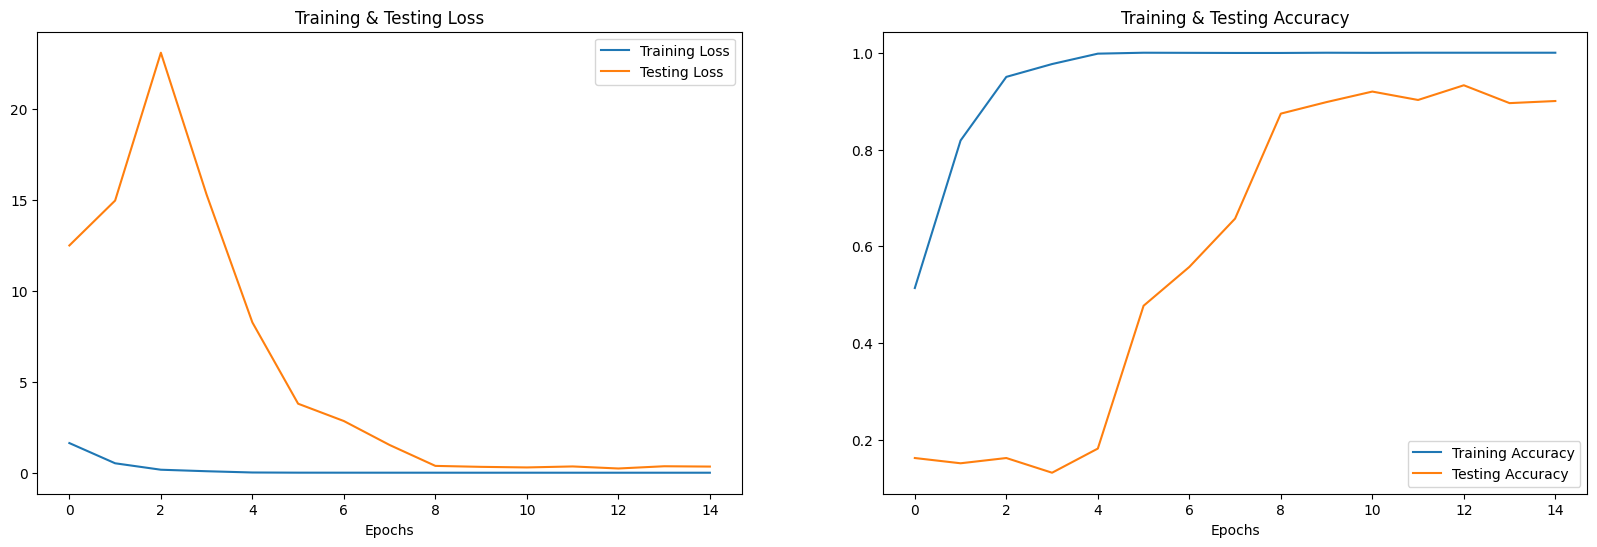

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

36/36 [==============================] - 5s 145ms/step


array([3, 4, 4, ..., 5, 6, 0], dtype=int64)

In [ ]:
y_check = np.argmax(y_test, axis=1)
y_check

array([3, 4, 4, ..., 5, 6, 6], dtype=int64)

In [ ]:
cm = confusion_matrix(y_true=y_check, y_pred=y_pred)
print(cm)

[[133   4   0   0   0   1   1]
 [  5 156   0   0   0   1   0]
 [  4   1 117   1   8   0   7]
 [  5   1   5 128   6   2  10]
 [  0   1   0   1 239   3   2]
 [  3   4   7   2  11 129   7]
 [  2   1   1   3   3   0 137]]


In [ ]:
print(classification_report(y_check, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.91       139
           1       0.93      0.96      0.95       162
           2       0.90      0.85      0.87       138
           3       0.95      0.82      0.88       157
           4       0.90      0.97      0.93       246
           5       0.95      0.79      0.86       163
           6       0.84      0.93      0.88       147

    accuracy                           0.90      1152
   macro avg       0.90      0.90      0.90      1152
weighted avg       0.91      0.90      0.90      1152



In [ ]:

print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

36/36 [==============================] - 6s 159ms/step - loss: 0.4148 - acc: 0.9019 - f1_m: 0.8987
Accuracy of our model on test data :  90.19097089767456 %


In [ ]:
#CNN
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

y_test = np.argmax(y_test, axis=1)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

36/36 [==============================] - 6s 154ms/step


Predicted Labels  Actual Labels
0                 3              3
1                 4              4
2                 4              4
3                 4              4
4                 4              4
5                 0              0
6                 3              3
7                 1              1
8                 2              2
9                 1              1

In [ ]:
model_name = 'model_new_cnn2_acc_90.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at d:\PYTHON\Speech_Emotion_recognition\Code_File\saved_models\model_new_cnn2_acc_90.h5 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("D:\PYTHON\saved_models\model_new_cnn_acc_93.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
y_pred = loaded_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

36/36 [==============================] - 6s 155ms/step


Predicted Labels  Actual Labels
0                 3              3
1                 4              4
2                 4              4
3                 4              4
4                 4              4
5                 0              0
6                 3              3
7                 1              1
8                 2              2
9                 1              1

# CNN AND LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
model03 = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=9, strides=1, padding='same', input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(filters=64, kernel_size=7, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(filters=128, kernel_size=7, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.LSTM(32, return_sequences=True),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(units=7, activation='softmax')
        ])

model03.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_23 (Conv1D)          (None, 2160, 32)          320       
                                                                 
 batch_normalization_23 (Bat  (None, 2160, 32)         128       
 chNormalization)                                                
                                                                 
 activation_23 (Activation)  (None, 2160, 32)          0         
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 1080, 32)         0         
 g1D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 1080, 32)          0         
                                                                 
 conv1d_24 (Conv1D)          (None, 1080, 64)         

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-3, momentum=0.8)

In [ ]:
model03.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model03.fit(X_train, y_train, batch_size=64, epochs=150, validation_data=(X_val, y_val))

Epoch 1/150
65/65 [==============================] - 38s 556ms/step - loss: 1.7473 - categorical_accuracy: 0.3091 - val_loss: 1.8389 - val_categorical_accuracy: 0.2495
Epoch 2/150
65/65 [==============================] - 42s 648ms/step - loss: 1.5200 - categorical_accuracy: 0.4259 - val_loss: 1.9959 - val_categorical_accuracy: 0.2798
Epoch 3/150
65/65 [==============================] - 42s 641ms/step - loss: 1.3729 - categorical_accuracy: 0.4857 - val_loss: 1.8599 - val_categorical_accuracy: 0.3015
Epoch 4/150
65/65 [==============================] - 44s 673ms/step - loss: 1.2371 - categorical_accuracy: 0.5457 - val_loss: 1.8666 - val_categorical_accuracy: 0.3731
Epoch 5/150
65/65 [==============================] - 45s 700ms/step - loss: 1.1128 - categorical_accuracy: 0.5874 - val_loss: 1.7571 - val_categorical_accuracy: 0.3948
Epoch 6/150
65/65 [==============================] - 42s 637ms/step - loss: 1.0535 - categorical_accuracy: 0.6168 - val_loss: 1.3498 - val_categorical_accuracy:

36/36 [==============================] - 3s 83ms/step - loss: 0.5127 - categorical_accuracy: 0.8264
Accuracy of our model on test data :  82.63888955116272 %


KeyError: 'acc'

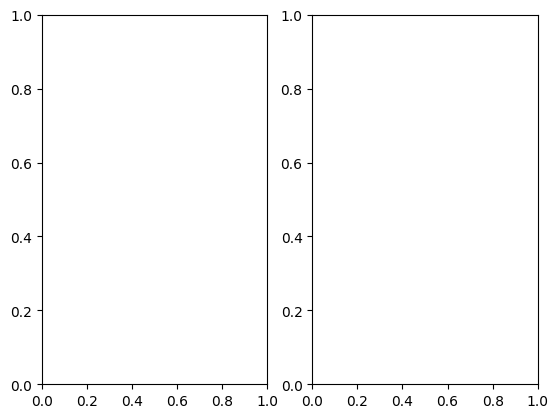

In [ ]:
print("Accuracy of our model on test data : " , model03.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [ ]:
y_pred = model03.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

36/36 [==============================] - 4s 90ms/step


array([5, 4, 4, ..., 5, 6, 3], dtype=int64)

In [ ]:
y_check = np.argmax(y_test, axis=1)
y_check

array([3, 4, 4, ..., 5, 6, 6], dtype=int64)

In [ ]:
cm = confusion_matrix(y_true=y_check, y_pred=y_pred)
print(cm)

[[116  12   1   6   2   2   0]
 [  6 135   2   1   8   8   2]
 [  6   3 109   6   4   3   7]
 [  1   4   5 132   8   6   1]
 [  0   3   2   3 225  11   2]
 [  0   2   3  11  20 125   2]
 [  3   3   8  16   2   5 110]]


In [ ]:
#CNN
y_pred = model03.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

y_test = np.argmax(y_test, axis=1)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

36/36 [==============================] - 3s 91ms/step


Predicted Labels  Actual Labels
0                 5              3
1                 4              4
2                 4              4
3                 4              4
4                 4              4
5                 0              0
6                 3              3
7                 1              1
8                 2              2
9                 1              1

In [ ]:
model_name = 'model_new_cnn&lstm_acc_.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model03.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at d:\PYTHON\Speech_Emotion_recognition\Code_File\saved_models\model_new_cnn&lstm_acc_.h5 


In [ ]:
import json
model_json = model03.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("D:\PYTHON\saved_models\model_new_cnn&lstm_acc_.h5")
print("Loaded model from disk")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'D:\PYTHON\saved_models\model_new_cnn&lstm_acc_.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)